In [122]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import explained_variance_score, mean_absolute_error, mean_squared_error, r2_score

## Notes to consider for the challenge

1. Pre-process the data is somewhat complete, though we may need to confirm between the group to check if this is the best representation of data.
 - We found the mean of each column from the data base (Concrete_Data_Yeh_final.csv) - but is this the right approach?

2. Try to do a function that goes through all types of regression and format a demo plot to see if this regression is appropriate for one column.
 - If results are satisfactory, we need to firm this type of regression for each column.


In [123]:
filename = 'Concrete_Data_Yeh_final.csv'
variables = ['cement', 'slag', 'flyash', 'water', 'superplasticizer', 'coarseaggregate', 'fineaggregate', 'age', 'csMPa']

class PreProcessing:
    "The aim of this class is to successfully replace all the empty values from"
    "the file given, and to split the columns into their own series / arrays."
    def __init__(self, file):
        self.data = pd.read_csv(file)
        
    def checkNaN (self):
        return self.data.isnull().sum()
    
    def FillNaN (self) -> pd.DataFrame:
        # Here we used the .mean method to replace the NaN values from the original dataset. 
        # (Please check this as we may use an alternative fillna method)
        for i in self.data.columns:
            self.data[i].fillna(self.data[i].mean(), inplace = True)
        return self.data
    
test = PreProcessing(filename).checkNaN()
print('Number of NaN values in each column from the original csv file: \n' ,test)

concretedata = PreProcessing(filename).FillNaN()
concretedata.head(10)

Number of NaN values in each column from the original csv file: 
 cement               0
slag                 6
flyash               1
water                8
superplasticizer    14
coarseaggregate      7
fineaggregate        3
age                  5
csMPa                0
dtype: int64


,cement,slag,flyash,water,superplasticizer,coarseaggregate,fineaggregate,age,csMPa
0,540.0,0.0,0.0,162.000000,2.500000,1040.0,676.0,28.000000,79.99
1,540.0,0.0,0.0,162.000000,2.500000,1055.0,676.0,28.000000,61.89
2,332.5,142.5,0.0,228.000000,0.000000,932.0,594.0,270.000000,40.27
3,332.5,142.5,0.0,228.000000,0.000000,932.0,594.0,45.427317,41.05
4,198.6,132.4,0.0,192.000000,0.000000,978.4,825.5,360.000000,44.30
5,266.0,114.0,0.0,228.000000,6.219882,932.0,670.0,90.000000,47.03
6,380.0,95.0,0.0,228.000000,0.000000,932.0,594.0,365.000000,43.70
7,380.0,95.0,0.0,228.000000,0.000000,932.0,594.0,28.000000,36.45
8,266.0,114.0,0.0,181.506262,0.000000,932.0,670.0,28.000000,45.85
9,475.0,0.0,0.0,228.000000,0.000000,932.0,594.0,28.000000,39.29


In [124]:
# Provides the statistical summary of the data #
concretedata.describe()

,cement,slag,flyash,water,superplasticizer,coarseaggregate,fineaggregate,age,csMPa
count,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000
mean,281.167864,73.668652,54.122838,181.506262,6.219882,972.653959,773.698150,45.427317,35.817961
std,104.506364,85.973892,63.962458,21.039881,5.925527,77.659130,79.896863,62.324091,16.705742
min,102.000000,0.000000,0.000000,121.800000,0.000000,801.000000,594.000000,1.000000,2.330000
25%,192.375000,0.000000,0.000000,164.900000,0.000000,932.000000,733.250000,7.000000,23.710000
50%,272.900000,22.000000,0.000000,185.000000,6.350000,968.000000,779.300000,28.000000,34.445000
75%,350.000000,142.500000,118.300000,192.000000,10.175000,1029.150000,824.000000,56.000000,46.135000
max,540.000000,359.400000,200.100000,247.000000,32.200000,1145.000000,992.600000,365.000000,82.600000


### Training / Test data -> Scaling the Data
We will scale variables via MinMaxScaler (from sklearn.PreProcessing) here to understand and have easier comparison between variables, as they will be all under the same axis. It is better to scale such data before performing regression or any other machine learning algorithms that may follow. Statistical Data has been referenced as well to see how the numbers have adjusted.

In [125]:
# Create a scaler
scaler = MinMaxScaler()

# Split the DataFrame into training and testing sets - train_test_split is a function from sklearn.
trainingconcretedata, testingconcretedata = train_test_split(concretedata, test_size=0.2, random_state=42)

# Fit the scaler on the training set and transform it
CDtrainscale = pd.DataFrame(scaler.fit_transform(trainingconcretedata), columns=concretedata.columns)

# Transform the testing set
CDtestscale = pd.DataFrame(scaler.transform(testingconcretedata), columns=concretedata.columns)


In [126]:
# To check if the general shape of both the training and testing sets are reasonable. This can be adjusted if bias is found. #
print(CDtrainscale.shape, CDtestscale.shape)

(824, 9) (206, 9)


### Building the Regression Model
1. Will go through each type of regression technique (Linear, Ridge, Lasso and ElasticNet) via .fit() on the training data - this will determine which regression technique is best. To support the fit, .coef_ and .intercept are used as well on the training sets. The test set will undergo the .score() and .predict() functions to be applied on the training data.
 
To Note: The original x and y data (x and y) will be saved for future reference if they need to be used, e.g. plotting the graphs.


In [127]:
#  Note: The regression model is only applied to the scaled data sets.
def RegressionModel(testset, trainset, regression, metriclist):
    heatmapdata = {}
    for i in testset.columns[:-1]:

        x_test = testset[i].to_numpy().reshape(-1,1)
        y_test = testset['csMPa'].to_numpy().reshape(-1,1)
        x_train = trainset[i].to_numpy().reshape(-1,1)
        y_train = trainset['csMPa'].to_numpy().reshape(-1,1)

        regressor = regression()
        regressor.fit(x_train, y_train)
        y_pred = regressor.predict(x_test)
        heatmapdata[i] = float(regressor.coef_)
        
        metrics = []
        for j in metriclist:
        # Append a tuple with the metric name and value to the list
            metrics.append((j.__name__, j(y_test, y_pred)))
        print (pd.DataFrame(metrics, columns=['Metric', 'Value']))

        plt.figure(figsize=(8, 4))
        plt.scatter(x_test, y_test, color='blue', label='Actual', s=5)
        plt.plot(x_test, y_pred, color='red', label='Predicted')
        plt.title(f'Score: {regressor.score(x_test, y_test)}, Gradient: {regressor.coef_}')
        plt.xlabel(i)
        plt.ylabel('Compression Strength (MPa)')
        plt.legend()
        plt.show()
    return heatmapdata

# Note: The gradient of the regression line is the coefficient of the regression model for each variable. I think??

                     Metric     Value
0  explained_variance_score  0.252256
1       mean_absolute_error  0.144059
2        mean_squared_error  0.029967
3                  r2_score  0.250678


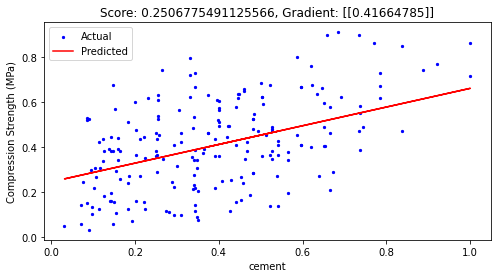

                     Metric     Value
0  explained_variance_score -0.009350
1       mean_absolute_error  0.162793
2        mean_squared_error  0.040369
3                  r2_score -0.009442


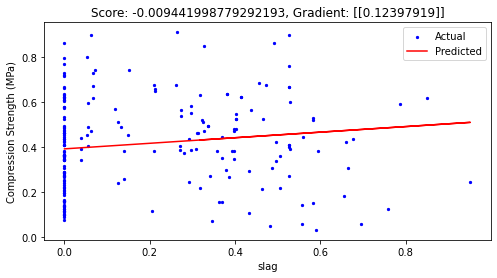

                     Metric     Value
0  explained_variance_score -0.048536
1       mean_absolute_error  0.166500
2        mean_squared_error  0.041933
3                  r2_score -0.048536


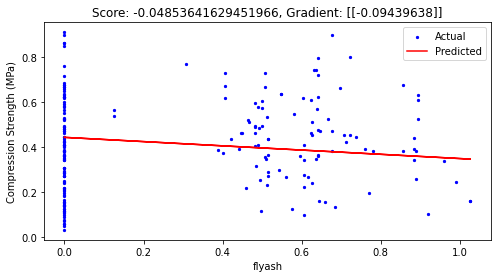

                     Metric     Value
0  explained_variance_score  0.097277
1       mean_absolute_error  0.156387
2        mean_squared_error  0.036132
3                  r2_score  0.096504


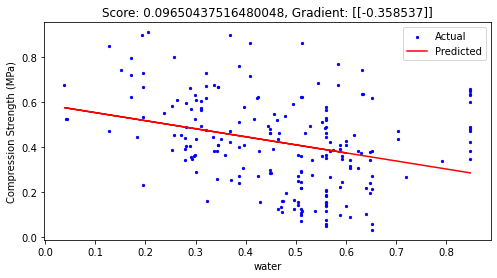

                     Metric     Value
0  explained_variance_score  0.168859
1       mean_absolute_error  0.148975
2        mean_squared_error  0.033258
3                  r2_score  0.168375


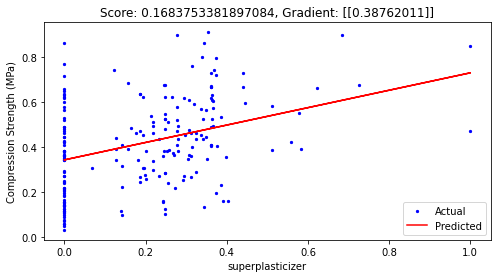

                     Metric     Value
0  explained_variance_score  0.016362
1       mean_absolute_error  0.160449
2        mean_squared_error  0.039352
3                  r2_score  0.015992


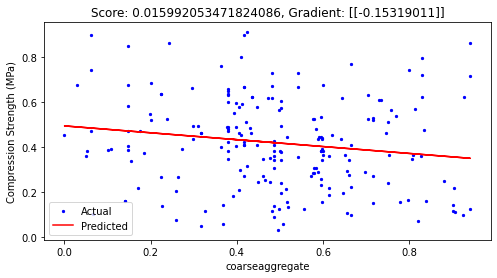

                     Metric     Value
0  explained_variance_score  0.035348
1       mean_absolute_error  0.159976
2        mean_squared_error  0.038578
3                  r2_score  0.035346


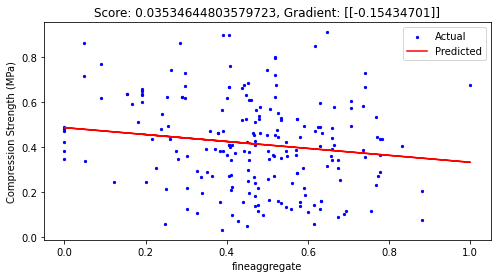

                     Metric     Value
0  explained_variance_score  0.109953
1       mean_absolute_error  0.154215
2        mean_squared_error  0.035632
3                  r2_score  0.109001


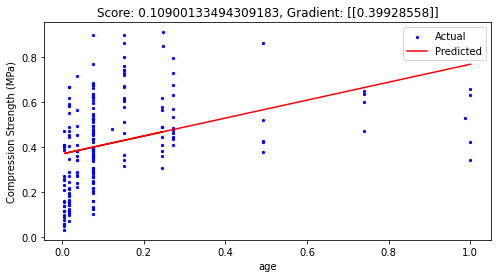

In [128]:
heatmapdata = RegressionModel(CDtestscale, CDtrainscale, Ridge, metrics)

Text(0.5, 1.0, 'Gradient of variables against Compressive Strength using Linear Regression')

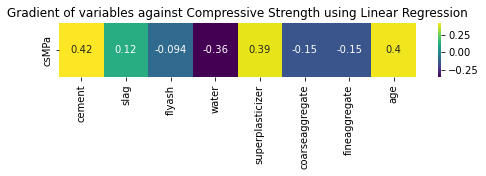

In [129]:
# Create the heatmap to show the trends with variables against Compressive Strength.
df = pd.DataFrame([heatmapdata])
df.index = ['csMPa']
plt.figure(figsize=(8, 1))
sns.heatmap(df, annot=True, cmap='viridis')
plt.title('Gradient of variables against Compressive Strength using Linear Regression')

In [130]:
# To clarify the common number that appears on slag, flyash and superplasticizer.
concretedata.mode()

,cement,slag,flyash,water,superplasticizer,coarseaggregate,fineaggregate,age,csMPa
0,362.6,0.0,0.0,192.0,0.0,932.0,594.0,28.0,33.4
1,425.0,NaN,NaN,NaN,NaN,NaN,755.8,NaN,NaN


## Observations from this Model
To start, this code works well with LinearRegression and RidgeRegression but not Lasso nor RandomForest (please get that sorted!).

Using the Figures from the definition and the heatmap provided the following observations can be made:
1. Cement, Superplasticiser and Age are the 3 main contributors to the increase of Compressive Strength (csMPa)
2. Inversely, Water has the biggest decrease in csMPa - which isnt a surprise.
3. Slag, Flyash, Superplastistizer and (maybe?) Age have a dominant display of 0. This would result in skewed data, so is there a way around this?

Of course, the model I have made is not perfect, you can easily improve this code to fit all the criteria mentioned.

### Whats next?

Once we got the hang of justifying our observations, we need to make an interactive graph that reflects the trends of each input variable to the overall compressive strength. To aid this, read the notes and tasks from Lecture 2 about how to make the interactive graph and its corresponding features.

Hope this code is good enough for you guys <3
Mervyn